#https://wikidocs.net/175794
https://github.com/RichardMinsooGo-RL-Gym/Bible_4_VI_TF2_A_DQN_Value_Iterations

In [1]:
import sys
#IN_COLAB = "google.colab" in sys.modules

import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import optimizers, losses
from tensorflow.keras import Model
from collections import deque

from IPython.display import clear_output
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

2024-12-23 10:35:50.693558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 10:35:50.702032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 10:35:50.711578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 10:35:50.714323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 10:35:50.721947: I tensorflow/core/platform/cpu_feature_guar

In [2]:
solved_threshold = 195
episode_rewards = []
rolling_avg_rewards = []

target_update = 100

# INITIALIZING THE Q-PARAMETERS
hidden_size = 128
max_episodes = 1000  # Set total number of episodes to train agent on.
batch_size = 64

# Exploration parameters
epsilon = 1.0                 # Exploration rate
epsilon_decay = 0.99          # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
epsilon_min = 0.01


In [3]:
# CREATING THE Dueling Q-Network
# Neural Network Model Defined at Here.
class Network(Model):
    def __init__(self, state_size: int, action_size: int, 
    ):
        """Initialization."""
        super(Network, self).__init__()
        
        self.num_action = action_size
        self.layer1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.state  = tf.keras.layers.Dense(self.num_action)
        self.action = tf.keras.layers.Dense(self.num_action)

    def call(self, state):
        layer1 = self.layer1(state)
        layer2 = self.layer2(layer1)
        state = self.state(layer2)
        action = self.action(layer2)
        mean = tf.keras.backend.mean(action, keepdims=True)
        advantage = (action - mean)
        value = state + advantage        
        return value

class DQNAgent:
    def __init__(
        self, 
        env: gym.Env,
        batch_size: int,
        target_update: int,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        
        # CREATING THE Q-Network
        self.env = env
        
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        self.batch_size = batch_size
        # hyper parameters
        self.lr = 0.001
        self.target_update = target_update
        self.gamma = 0.99
        
        self.dqn = Network(self.state_size, self.action_size
                          )
        self.dqn_target = Network(self.state_size, self.action_size
                          )
        self.optimizers = optimizers.Adam(learning_rate =self.lr, )
        
        self.memory = deque(maxlen=2000)
        
        self._target_hard_update()
        
    # 3.4.1 EXPLORATION VS EXPLOITATION
    def get_action(self, state, epsilon):
        q_value = self.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
        # 3. Choose an action a in the current world state (s)
        # If this number < greater than epsilon doing a random choice --> exploration
        if np.random.rand() <= epsilon:
            action = np.random.choice(self.action_size)

        ## Else --> exploitation (taking the biggest Q value for this state)
        else:
            action = np.argmax(q_value) 

        return action
    
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 3.4.2 UPDATING THE Q-VALUE
    def train_step(self):
        mini_batch = random.sample(self.memory, self.batch_size)

        states      = [i[0] for i in mini_batch]
        actions     = [i[1] for i in mini_batch]
        rewards     = [i[2] for i in mini_batch]
        next_states = [i[3] for i in mini_batch]
        dones       = [i[4] for i in mini_batch]
        
        dqn_variable = self.dqn.trainable_variables
        with tf.GradientTape() as tape:
#            tape.watch(dqn_variable)
            
            states      = tf.convert_to_tensor(np.vstack(states), dtype=tf.float32)
            actions     = tf.convert_to_tensor(actions, dtype=tf.int32)
            rewards     = tf.convert_to_tensor(rewards, dtype=tf.float32)
            next_states = tf.convert_to_tensor(np.vstack(next_states), dtype=tf.float32)
            dones       = tf.convert_to_tensor(dones, dtype=tf.float32)
            
            # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
            #       = r                       otherwise
            curr_Qs    = self.dqn(states)
            main_value = tf.reduce_sum(tf.one_hot(actions, self.action_size) * curr_Qs, axis=1)
            ## Obtain the Q' values by feeding the new state through our network
            next_Q_targs = self.dqn_target(next_states)
            next_action  = tf.argmax(next_Q_targs, axis=1)
            target_value = tf.reduce_sum(tf.one_hot(next_action, self.action_size) * next_Q_targs, axis=1)
            
            mask = 1 - dones
            target_value = rewards + self.gamma * target_value * mask 
            
            error = tf.square(main_value - target_value) * 0.5
            loss  = tf.reduce_mean(error)
            
        dqn_grads = tape.gradient(loss, dqn_variable)
        self.optimizers.apply_gradients(zip(dqn_grads, dqn_variable))
        
    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.set_weights(self.dqn.get_weights())

In [4]:
# CREATING THE ENVIRONMENT
env_name = "CartPole-v1"
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# train
agent = DQNAgent(
    env, 
#     memory_size, 
    batch_size, 
    target_update, 
#     epsilon_decay,
)

I0000 00:00:1734946551.800314  700541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734946551.819198  700541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734946551.819236  700541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734946551.821123  700541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734946551.821153  700541 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
update_cnt    = 0
# 2.5 TRAINING LOOP
#List to contain all the rewards of all the episodes given to the agent
scores = []
    
# 2.6 EACH EPISODE    
for episode in range(max_episodes):

    state, _ = agent.env.reset()
    episode_reward = 0
    done = False  
        
    while not done:
        action = agent.get_action(state, epsilon)
            
        next_state, reward, done, _, _ = agent.env.step(action)
        agent.append_sample(state, action, reward, next_state, done)
        state = next_state

        episode_reward += reward

        if done:
            scores.append(episode_reward)
#            print("Episode " + str(episode+1) + ": " + str(episode_reward))
            break
            
        if (len(agent.memory) >= agent.batch_size):
            # 3.4.2 UPDATING THE Q-VALUE
            agent.train_step()
            update_cnt += 1
            
            # if hard update is needed
            if update_cnt % agent.target_update == 0:
                agent._target_hard_update()
    
    
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    # Record reward
    episode_rewards.append(episode_reward)
    rolling_avg = np.mean(episode_rewards[-20:])
    rolling_avg_rewards.append(rolling_avg)

    # Print progress
    print(f"Episode: {episode+1:3}/{max_episodes}, Reward: {episode_reward:+8.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Terminated: {done} ")

    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        break
        

Episode:   1/1000, Reward:   +15.00, Epsilon: 0.99, Rolling Avg:  15.00, Terminated: True 
Episode:   2/1000, Reward:   +18.00, Epsilon: 0.98, Rolling Avg:  16.50, Terminated: True 
Episode:   3/1000, Reward:   +49.00, Epsilon: 0.97, Rolling Avg:  27.33, Terminated: True 
Episode:   4/1000, Reward:   +12.00, Epsilon: 0.96, Rolling Avg:  23.50, Terminated: True 
Episode:   5/1000, Reward:   +46.00, Epsilon: 0.95, Rolling Avg:  28.00, Terminated: True 
Episode:   6/1000, Reward:   +10.00, Epsilon: 0.94, Rolling Avg:  25.00, Terminated: True 
Episode:   7/1000, Reward:   +14.00, Epsilon: 0.93, Rolling Avg:  23.43, Terminated: True 
Episode:   8/1000, Reward:   +18.00, Epsilon: 0.92, Rolling Avg:  22.75, Terminated: True 
Episode:   9/1000, Reward:   +15.00, Epsilon: 0.91, Rolling Avg:  21.89, Terminated: True 
Episode:  10/1000, Reward:   +13.00, Epsilon: 0.90, Rolling Avg:  21.00, Terminated: True 
Episode:  11/1000, Reward:   +15.00, Epsilon: 0.90, Rolling Avg:  20.45, Terminated: True 

Episode:  92/1000, Reward:  +105.00, Epsilon: 0.40, Rolling Avg:  74.35, Terminated: True 
Episode:  93/1000, Reward:   +34.00, Epsilon: 0.39, Rolling Avg:  61.75, Terminated: True 
Episode:  94/1000, Reward:  +124.00, Epsilon: 0.39, Rolling Avg:  60.60, Terminated: True 
Episode:  95/1000, Reward:  +144.00, Epsilon: 0.38, Rolling Avg:  65.65, Terminated: True 
Episode:  96/1000, Reward:  +157.00, Epsilon: 0.38, Rolling Avg:  72.00, Terminated: True 
Episode:  97/1000, Reward:   +12.00, Epsilon: 0.38, Rolling Avg:  70.75, Terminated: True 
Episode:  98/1000, Reward:  +215.00, Epsilon: 0.37, Rolling Avg:  78.95, Terminated: True 
Episode:  99/1000, Reward:  +204.00, Epsilon: 0.37, Rolling Avg:  87.55, Terminated: True 
Episode: 100/1000, Reward:   +48.00, Epsilon: 0.37, Rolling Avg:  86.40, Terminated: True 
Episode: 101/1000, Reward:  +182.00, Epsilon: 0.36, Rolling Avg:  88.25, Terminated: True 
Episode: 102/1000, Reward:  +215.00, Epsilon: 0.36, Rolling Avg:  98.30, Terminated: True 

Episode: 183/1000, Reward:  +128.00, Epsilon: 0.16, Rolling Avg: 124.85, Terminated: True 
Episode: 184/1000, Reward:  +124.00, Epsilon: 0.16, Rolling Avg: 125.45, Terminated: True 
Episode: 185/1000, Reward:  +196.00, Epsilon: 0.16, Rolling Avg: 129.20, Terminated: True 
Episode: 186/1000, Reward:  +212.00, Epsilon: 0.15, Rolling Avg: 133.15, Terminated: True 
Episode: 187/1000, Reward:  +665.00, Epsilon: 0.15, Rolling Avg: 160.30, Terminated: True 
Episode: 188/1000, Reward:  +530.00, Epsilon: 0.15, Rolling Avg: 181.15, Terminated: True 
Episode: 189/1000, Reward: +1154.00, Epsilon: 0.15, Rolling Avg: 234.75, Terminated: True 
Environment solved in 189 episodes!


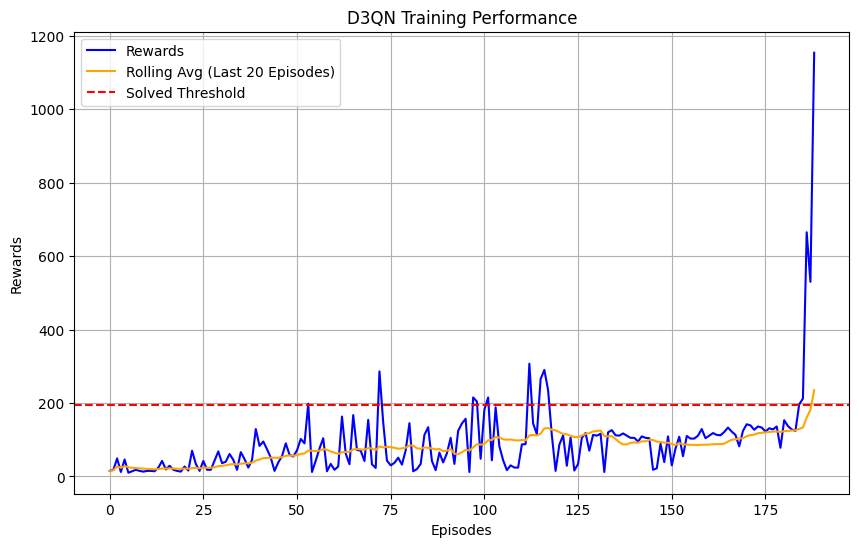

In [6]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 20 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('D3QN Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

In [7]:
# Testing for 10 episodes
start_time = time.time()
max_steps = 500

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    for s in range(max_steps):                            # we limit because sometimes it goes ad-aeternum
        # Use the trained model for testing
        action_vals = agent.dqn.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1

        if done or (steps == max_steps):
            print(f"Test Episode: {e_test + 1}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

I0000 00:00:1734947247.389576  700636 service.cc:146] XLA service 0x7f5478017740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734947247.389708  700636 service.cc:154]   StreamExecutor device (0): NVIDIA T600 Laptop GPU, Compute Capability 7.5
2024-12-23 10:47:27.396051: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-23 10:47:27.695404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1734947247.775659  700636 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Test Episode: 1/10, Reward: 257.00, Steps: 257
Test Episode: 2/10, Reward: 256.00, Steps: 256
Test Episode: 3/10, Reward: 263.00, Steps: 263
Test Episode: 4/10, Reward: 261.00, Steps: 261
Test Episode: 5/10, Reward: 254.00, Steps: 254
Test Episode: 6/10, Reward: 254.00, Steps: 254
Test Episode: 7/10, Reward: 258.00, Steps: 258
Test Episode: 8/10, Reward: 267.00, Steps: 267
Test Episode: 9/10, Reward: 257.00, Steps: 257
Test Episode: 10/10, Reward: 258.00, Steps: 258
Testing completed in 2.04 minutes


In [8]:
import session_info
session_info.show(html=False)

-----
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2024-12-23 10:49
